##**Importing Drive and Libaries**

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_recall_fscore_support, roc_curve, auc, f1_score
)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import warnings

##**Reading the CSV file**

In [124]:
file_path = '/content/drive/MyDrive/CM2604 Assignment/Telco-Customer-Churn.csv'
df = pd.read_csv(file_path)

##**Exploratory Data Analysis**

In [125]:
print(df.head()), print(df.shape)
df.info()

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [126]:
df[df['TotalCharges'] == ' '].shape

(11, 21)

In [127]:
# Clean TotalCharges
df['TotalCharges'] = df['TotalCharges'].replace(' ', pd.NA)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Impute missing TotalCharges: reasonable estimate = tenure * MonthlyCharges
df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'], inplace=True)

# Verify
df['TotalCharges'].isnull().sum()

np.int64(0)

In [128]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


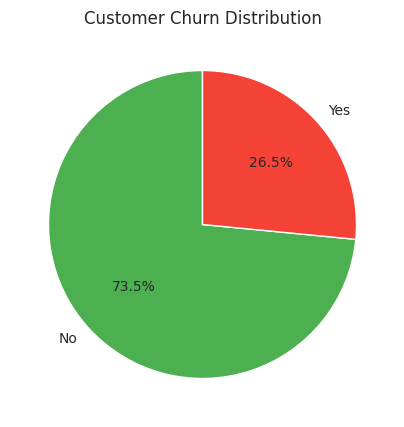

(Churn
 No     5174
 Yes    1869
 Name: count, dtype: int64,
 Churn
 No     73.463013
 Yes    26.536987
 Name: proportion, dtype: float64)

In [129]:
# Churn distribution
churn_counts = df['Churn'].value_counts()
churn_pct = df['Churn'].value_counts(normalize=True) * 100
labels = churn_counts.index
sizes = churn_counts.values

fig, ax = plt.subplots(figsize=(5,5))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#F44336'])
ax.set_title('Customer Churn Distribution')
plt.show()

churn_counts, churn_pct

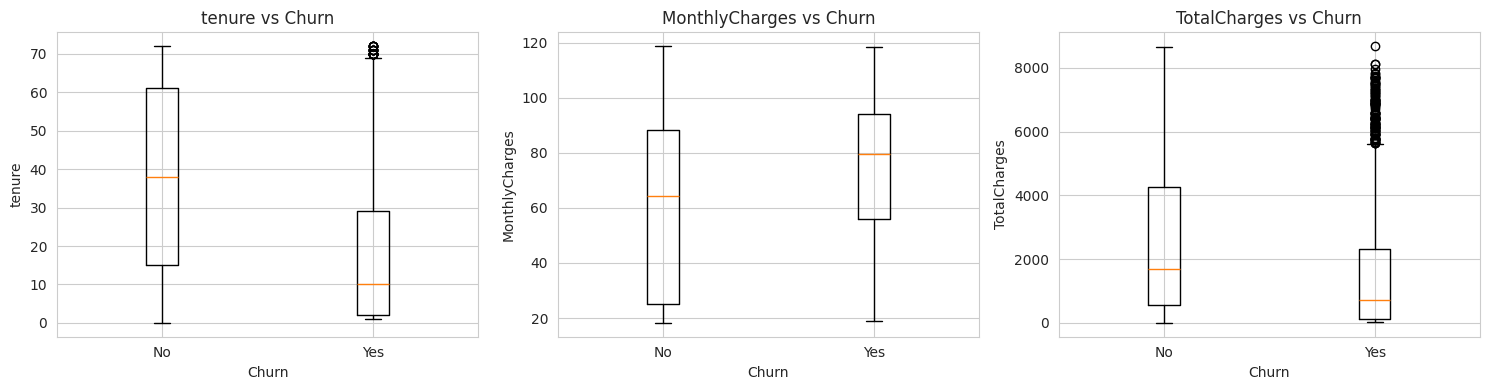

In [130]:
# Numeric features: tenure, MonthlyCharges, TotalCharges
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(numeric_cols):
    # Boxplot: churn vs not
    data = [df[df['Churn'] == 'No'][col], df[df['Churn'] == 'Yes'][col]]
    axes[i].boxplot(data, labels=['No', 'Yes'])
    axes[i].set_xlabel('Churn')
    axes[i].set_ylabel(col)
    axes[i].set_title(f'{col} vs Churn')

plt.tight_layout()
plt.show()

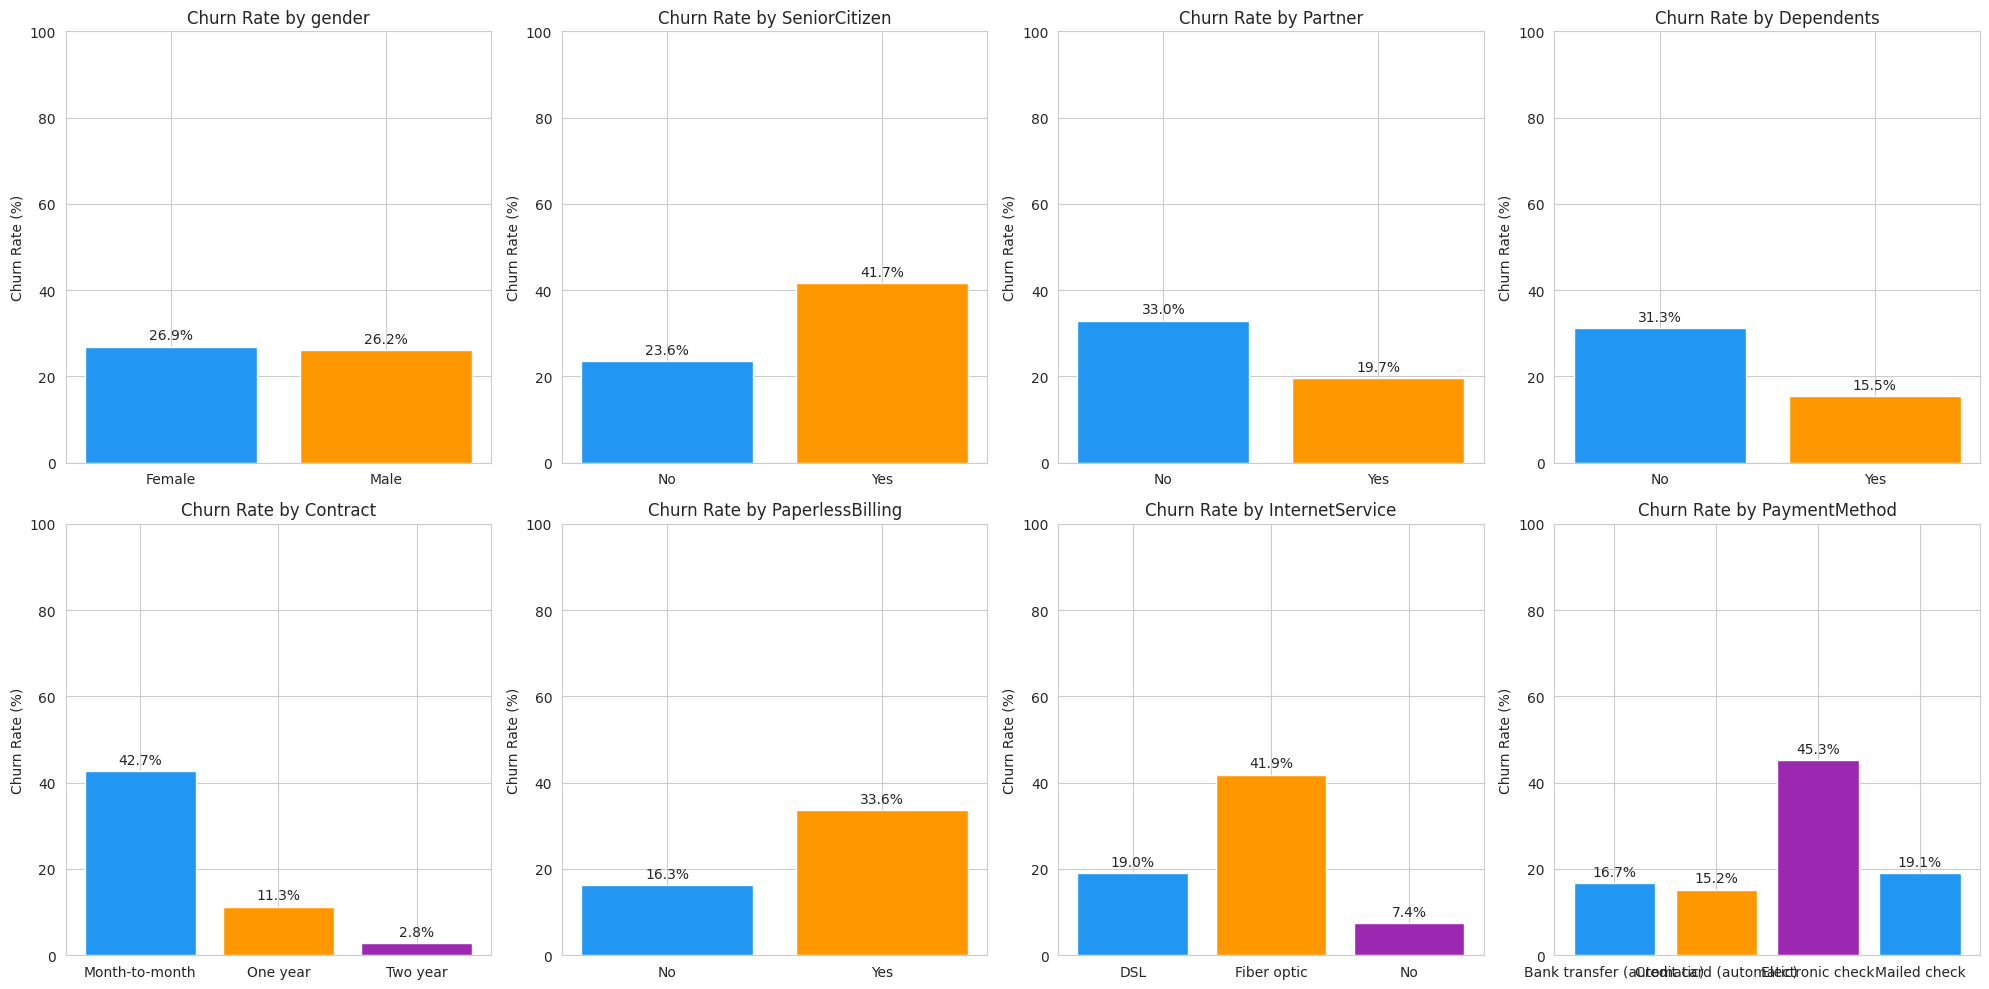

In [131]:
categorical_cols = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'Contract', 'PaperlessBilling', 'InternetService', 'PaymentMethod'
]

# Compute churn rate per category
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if col == 'SeniorCitizen':
        # Convert to string for plotting
        temp = df.copy()
        temp['SeniorCitizen'] = temp['SeniorCitizen'].map({0: 'No', 1: 'Yes'})
        col_name = 'SeniorCitizen'
    else:
        temp = df
        col_name = col

    churn_rate = temp.groupby(col_name)['Churn'].apply(lambda x: (x == 'Yes').mean()) * 100
    ax = axes[i]
    bars = ax.bar(churn_rate.index, churn_rate.values, color=['#2196F3', '#FF9800', '#9C27B0'][:len(churn_rate)])
    ax.set_title(f'Churn Rate by {col}')
    ax.set_ylabel('Churn Rate (%)')
    ax.set_ylim(0, 100)
    # Add percentage labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

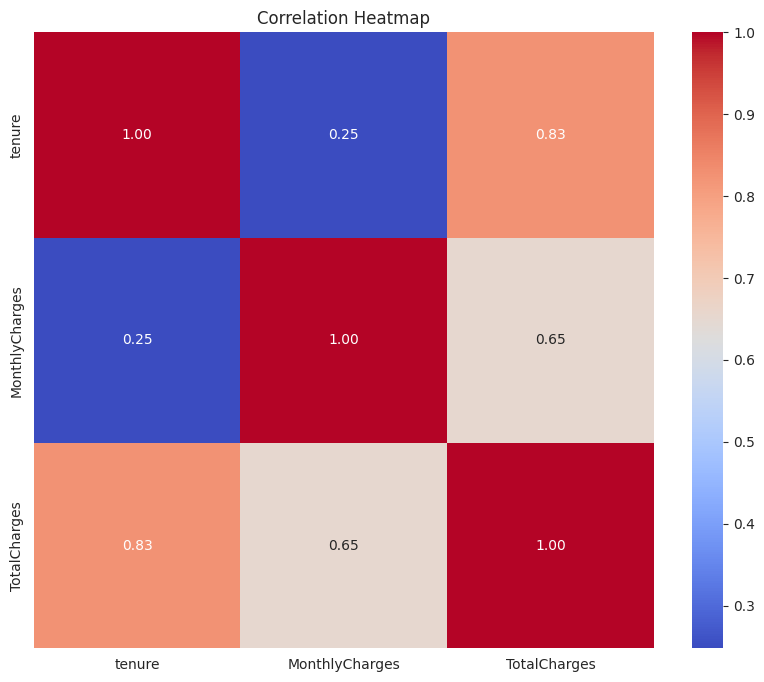

In [132]:
# Correlation Heatmap
corr_matrix = df[['tenure', 'MonthlyCharges', 'TotalCharges']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

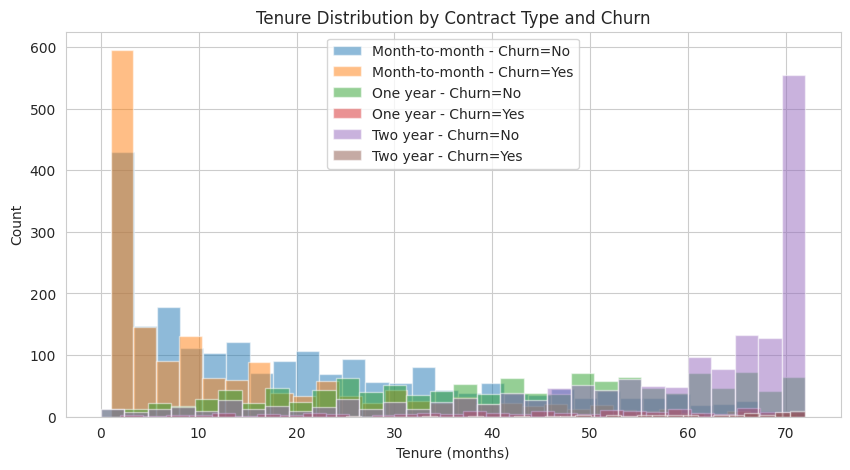

In [133]:
# Tenure histogram by Contract and Churn
fig, ax = plt.subplots(figsize=(10, 5))

for contract in df['Contract'].unique():
    for churn in ['No', 'Yes']:
        subset = df[(df['Contract'] == contract) & (df['Churn'] == churn)]
        ax.hist(subset['tenure'], bins=30, alpha=0.5,
                label=f'{contract} - Churn={churn}',
                density=False)

ax.set_xlabel('Tenure (months)')
ax.set_ylabel('Count')
ax.set_title('Tenure Distribution by Contract Type and Churn')
ax.legend()
plt.show()

In [134]:
# Check for any remaining missing/empty values
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


Maintain the flow in the pipeline

In [135]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [136]:
# ----------------------------
# 1. Clean Data
# ----------------------------
df = df.drop('customerID', axis=1)

# Fix TotalCharges
df.loc[df['tenure'] == 0, 'TotalCharges'] = 0.0

# Feature engineering
df['AvgMonthlyCharges'] = np.where(df['tenure'] > 0, df['TotalCharges'] / df['tenure'], df['MonthlyCharges'])

# Encode target
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'No': 0, 'Yes': 1}).astype(int)

print("=== DATA IMBALANCE METRICS ===")
print(f"Initial class distribution: {dict(y.value_counts())}")
print(f"% Churn (Yes): {y.mean():.2%}")
print()

=== 1. DATA IMBALANCE METRICS ===
Initial class distribution: {0: np.int64(5174), 1: np.int64(1869)}
% Churn (Yes): 26.54%



In [137]:
# ----------------------------
# 2. Split BEFORE balancing
# ----------------------------
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("=== BEFORE SMOTE (TRAIN SET) ===")
print(f"Train set size: {len(y_train)}")
print(f"Churn rate (train): {y_train.mean():.2%}")
print()

=== 2. BEFORE SMOTE (TRAIN SET) ===
Train set size: 4930
Churn rate (train): 26.53%



In [138]:
# ----------------------------
# 3. Preprocessing
# ----------------------------
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)

X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)
print(f"Preprocessed train shape: {X_train_prep.shape}")

Preprocessed train shape: (4930, 31)


In [139]:
# ----------------------------
# 4. Applyinng SMOTE — ONLY ON TRAIN
# ----------------------------
print("\n=== SMOTE (AFTER SPLIT!) ===")
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_prep, y_train)

print("=== BEFORE-AFTER STATISTICS ===")
print(f"Before SMOTE — Train: {len(y_train)} samples, Churn%: {y_train.mean():.2%}")
print(f"After SMOTE  — Train: {len(y_train_bal)} samples, Churn%: {y_train_bal.mean():.2%}")
print()


=== 9. SMOTE (AFTER SPLIT!) ===
=== 10. BEFORE-AFTER STATISTICS ===
Before SMOTE — Train: 4930 samples, Churn%: 26.53%
After SMOTE  — Train: 7244 samples, Churn%: 50.00%



In [140]:
# ----------------------------
# 5. Decision Tree (Tuned)
# ----------------------------
print("\n=== HYPERPARAMETER TUNING: DECISION TREE ===")
dt = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [3, 4],
    'min_samples_split': [40, 50, 60],
    'min_samples_leaf': [20, 30, 40],
    'criterion': ['gini']
}

grid_dt = GridSearchCV(dt, param_grid, cv=StratifiedKFold(5, shuffle=True, random_state=42), scoring='f1', n_jobs=-1)
grid_dt.fit(X_train_bal, y_train_bal)
best_dt = grid_dt.best_estimator_

# After initial DT fit:
dt_base = DecisionTreeClassifier(random_state=42)
dt_base.fit(X_train_bal, y_train_bal)

# Compute ccp_alphas
path = dt_base.cost_complexity_pruning_path(X_train_bal, y_train_bal)
ccp_alphas = path.ccp_alphas[:-1]  # exclude last (single node)

# Train pruned trees
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        random_state=42,
        ccp_alpha=ccp_alpha,
        min_samples_leaf=20  # still enforce minimum stability
    )
    clf.fit(X_train_bal, y_train_bal)
    clfs.append(clf)

# Evaluate on validation set (NOT train/test!)
val_scores = [f1_score(y_val, clf.predict(X_val_prep)) for clf in clfs]
best_idx = np.argmax(val_scores)
best_dt = clfs[best_idx]

print(f"Selected ccp_alpha = {ccp_alphas[best_idx]:.4f}")
print(f"Pruned tree depth = {best_dt.get_depth()}")
print(f"Leaves = {best_dt.get_n_leaves()}")

print(f"Best DT params: {grid_dt.best_params_}")
print(f"Best CV F1: {grid_dt.best_score_:.4f}")



=== 3. HYPERPARAMETER TUNING: DECISION TREE ===
Selected ccp_alpha = 0.0020
Pruned tree depth = 8
Leaves = 14
Best DT params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 40}
Best CV F1: 0.7821


In [141]:
# ----------------------------
# 6. Neural Network (Tuned via callbacks + architecture)
# ----------------------------
print("\n=== NEURAL NETWORK: Adam + Learning Rate + Early Stop ===")
n_features = X_train_bal.shape[1]

def create_model(lr=0.001):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(n_features,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )
    return model

model = create_model(lr=0.001)

# Callbacks
early_stop = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)

# Train
history = model.fit(
    X_train_bal, y_train_bal,
    validation_data=(X_val_prep, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)


=== 6–7. NEURAL NETWORK: Adam + Learning Rate + Early Stop ===


In [150]:
# ----------------------------
# 7. Evaluate Both Models
# ----------------------------
def get_metrics(y_true, y_pred, y_proba, name):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    auc_score = roc_auc_score(y_true, y_proba)
    cm = confusion_matrix(y_true, y_pred)
    return {'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'AUC': auc_score, 'CM': cm}

# DT
y_pred_dt = best_dt.predict(X_test_prep)
y_proba_dt = best_dt.predict_proba(X_test_prep)[:, 1]
dt_res = get_metrics(y_test, y_pred_dt, y_proba_dt, "Decision Tree (SMOTE)")

# NN
y_pred_nn = (model.predict(X_test_prep) > 0.5).astype(int).flatten()
y_proba_nn = model.predict(X_test_prep).flatten()
nn_res = get_metrics(y_test, y_pred_nn, y_proba_nn, "Neural Network (SMOTE)")

# ----------------------------
# 8. Evaluation Report
# ----------------------------
classification_report_dt = classification_report(y_test, y_pred_dt)
classification_report_nn = classification_report(y_test, y_pred_nn)
print("\nDecision Tree Classification Report:\n")
print(classification_report_dt)
print("\nNeural Network Classification Report:\n")
print(classification_report_nn)

print("\n=== Summery of the Classification Reports ===")
results_df = pd.DataFrame([dt_res, nn_res]).drop(columns=['CM'])
print(results_df.round(4).to_markdown(index=False))

print("\nDecision Tree Confusion Matrix:")
print(dt_res['CM'])
print("\nNeural Network Confusion Matrix:")
print(nn_res['CM'])


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Decision Tree Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.73      0.80       776
           1       0.50      0.75      0.60       281

    accuracy                           0.74      1057
   macro avg       0.70      0.74      0.70      1057
weighted avg       0.79      0.74      0.75      1057


Neural Network Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       776
           1       0.55      0.74      0.63       281

    accuracy                           0.77      1057
   macro avg       0.72      0.76      0.73      1057
weighted avg       0.80      0.77      0.78      1057


=== Summery of the Classification Reports ===
| Model                  |   Accuracy |   Precision |   Recall |     F1 |    AUC |
|:-----------------------|-----------:|------------:|------

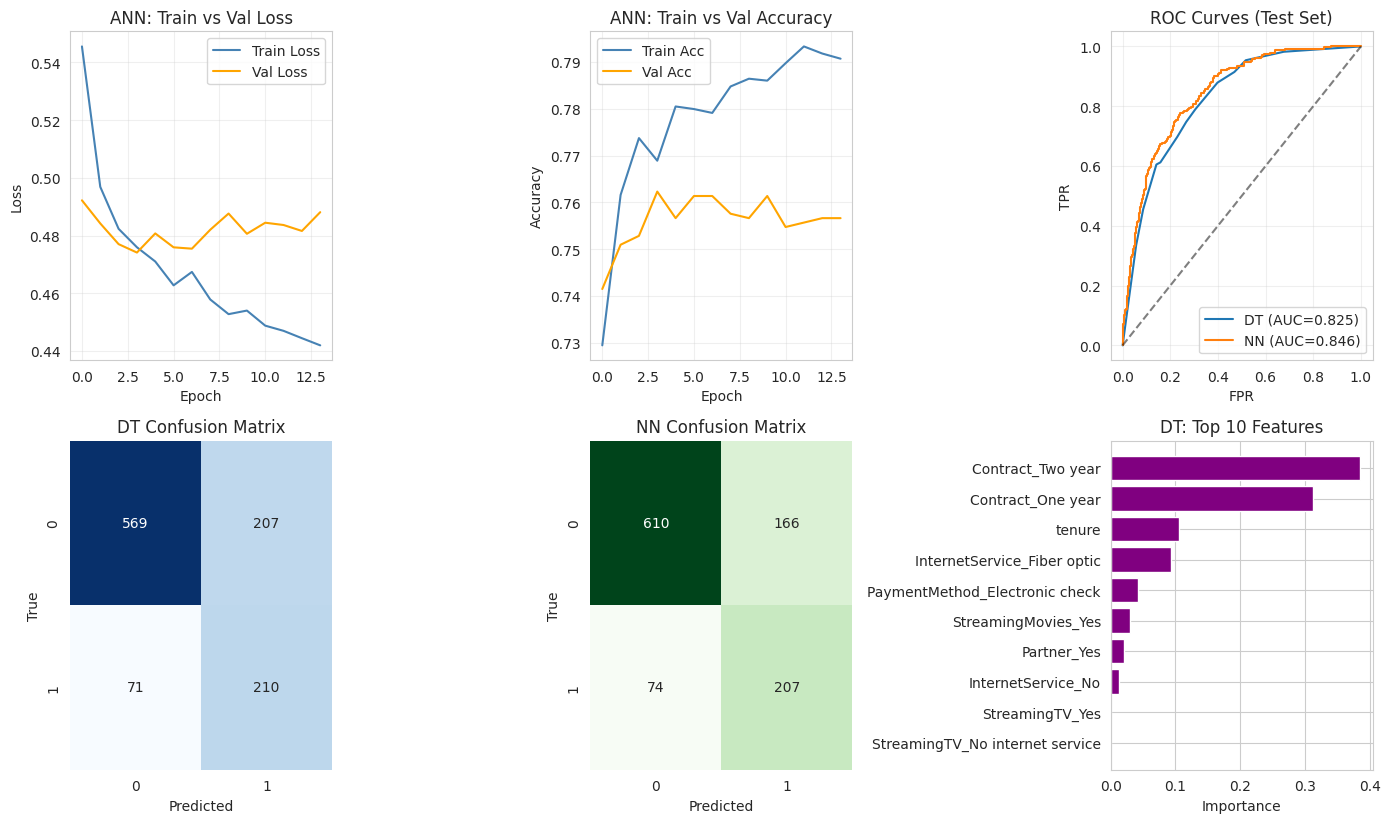

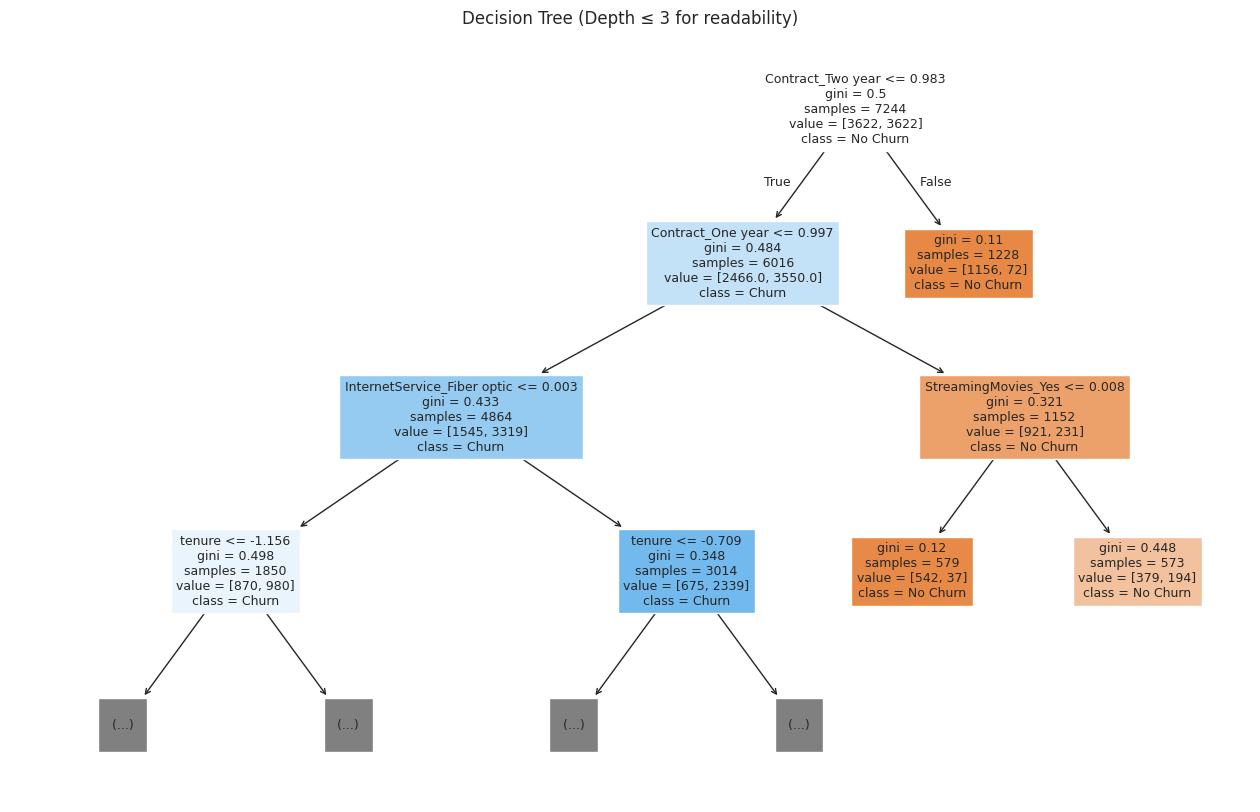

In [151]:
# ----------------------------
# 9. Visualizations
# ----------------------------
plt.figure(figsize=(14, 12))

# (a) Train/Test Loss
plt.subplot(3, 3, 1)
plt.plot(history.history['loss'], label='Train Loss', color='steelblue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('ANN: Train vs Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(alpha=0.3)

# (b) Train/Test Accuracy
plt.subplot(3, 3, 2)
plt.plot(history.history['accuracy'], label='Train Acc', color='steelblue')
plt.plot(history.history['val_accuracy'], label='Val Acc', color='orange')
plt.title('ANN: Train vs Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(alpha=0.3)

# (c) ROC Curves
plt.subplot(3, 3, 3)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_proba_nn)
plt.plot(fpr_dt, tpr_dt, label=f'DT (AUC={dt_res["AUC"]:.3f})')
plt.plot(fpr_nn, tpr_nn, label=f'NN (AUC={nn_res["AUC"]:.3f})')
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.title('ROC Curves (Test Set)')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.legend(); plt.grid(alpha=0.3)

# (d) Confusion Matrices
plt.subplot(3, 3, 4)
sns.heatmap(dt_res['CM'], annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('DT Confusion Matrix'); plt.ylabel('True'); plt.xlabel('Predicted')

plt.subplot(3, 3, 5)
sns.heatmap(nn_res['CM'], annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('NN Confusion Matrix'); plt.ylabel('True'); plt.xlabel('Predicted')

# (e) Feature Importance (Top 10)
plt.subplot(3, 3, 6)
feature_names = (
    num_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols))
)
importances = best_dt.feature_importances_
indices = np.argsort(importances)[-10:]
plt.barh(range(10), importances[indices], color='purple')
plt.yticks(range(10), [feature_names[i] for i in indices])
plt.title('DT: Top 10 Features')
plt.xlabel('Importance')

# (f) Learning Rate Schedule (if reduced)
if 'lr' in history.history:
    plt.subplot(3, 3, 7)
    plt.plot(history.history['lr'], color='red')
    plt.title('Learning Rate Schedule'); plt.xlabel('Epoch'); plt.ylabel('LR')
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('task2_visualizations.png', dpi=150, bbox_inches='tight')
plt.show()

# (g) DT Visualization (pruned)
plt.figure(figsize=(16, 10))
plot_tree(best_dt, max_depth=3, feature_names=feature_names,
          class_names=['No Churn', 'Churn'], filled=True, fontsize=9)
plt.title("Decision Tree (Depth ≤ 3 for readability)")
plt.savefig('dt_tree_viz.png', dpi=150, bbox_inches='tight')
plt.show()

In [152]:
# ----------------------------
# 10. Overfitting Check
# ----------------------------
train_acc_dt = accuracy_score(y_train_bal, best_dt.predict(X_train_bal))
test_acc_dt = dt_res['Accuracy']
train_acc_nn = history.history['accuracy'][-1]
test_acc_nn = nn_res['Accuracy']

print("\n=== OVERFITTING DIAGNOSTICS ===")
# DT
train_f1_dt = f1_score(y_train_bal, best_dt.predict(X_train_bal))
test_f1_dt = f1_score(y_test, y_pred_dt)
train_acc_dt = accuracy_score(y_train_bal, best_dt.predict(X_train_bal))
test_acc_dt = accuracy_score(y_test, y_pred_dt)

# NN
train_f1_nn = f1_score(y_train_bal, (model.predict(X_train_bal) > 0.5).astype(int).flatten())
test_f1_nn = f1_score(y_test, y_pred_nn)
train_acc_nn = accuracy_score(y_train_bal, (model.predict(X_train_bal) > 0.5).astype(int).flatten())
test_acc_nn = nn_res['Accuracy']

# Report gaps
print("=== Train-Test Gap Check (must be \u2264 0.05) ===")
print(f"DT  \u2192 Acc gap: {train_acc_dt - test_acc_dt:.3f}, F1 gap: {train_f1_dt - test_f1_dt:.3f}")
print(f"NN  \u2192 Acc gap: {train_acc_nn - test_acc_nn:.3f}, F1 gap: {train_f1_nn - test_f1_nn:.3f}")


=== OVERFITTING DIAGNOSTICS ===
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
=== Train-Test Gap Check (must be ≤ 0.05) ===
DT  → Acc gap: 0.056, F1 gap: 0.201
NN  → Acc gap: 0.007, F1 gap: 0.146
